In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [6]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [3]:
def HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbarf, Ncut), t2/3.0, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSigFront(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(thermPulse(psi0, t1/3.0, Omega0, delPrime, eta, nbar0, Ncut), 2.0*t1/3.0, -Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [11]:
pts = 15
Ncuts = np.array([201,401,601,801,901])
psi0 = psi(0.0, 1.0)
Delta = 1.0 #*(2.0*np.pi) #hz
Omega0 = 157.0 #*(2.0*np.pi) #hz
nbar0 = 10.0 
t1 = np.pi/(2.0*Omega0)
t2 = 3.0*np.pi/(2.0*Omega0)
T = 50.0e-3
eta = 0.05
nbarfs = np.linspace(10, 150, pts)
shifts1 = np.zeros([np.size(Ncuts), pts])
shifts2 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 5.0
for ii in range(np.size(Ncuts)):
    print(Ncuts[ii])
    x0 = -0.1
    x1 = 0.5
    for jj in range(pts):
        print(nbarfs[jj])
        shifts1[ii][jj] = sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarfs[jj], Ncuts[ii]), bracket=[x0,x1], xtol = tol).root
        #print(shifts1[ii])
        x0 = shifts1[ii][jj] - guessTol
        x1 = shifts1[ii][jj] + guessTol
        #print(x0,x1)

201
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
401
10.0


D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:553: RuntimeWarning: overflow encountered in multiply
  - (n + alpha)*cephes.eval_genlaguerre(n-1, alpha, x))/x
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:195: RuntimeWarning: invalid value encountered in true_divide
  dy /= np.abs(dy).max()


20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
601
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
801
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
901
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


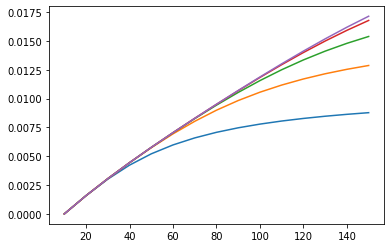

In [13]:
plt.plot(nbarfs, shifts1[0,:], label="Ncut=201" )
plt.plot(nbarfs, shifts1[1,:], label="Ncut=401" )
plt.plot(nbarfs, shifts1[2,:], label="Ncut=601" )
plt.plot(nbarfs, shifts1[3,:], label="Ncut=801" )
plt.plot(nbarfs, shifts1[4,:], label="Ncut=901" )

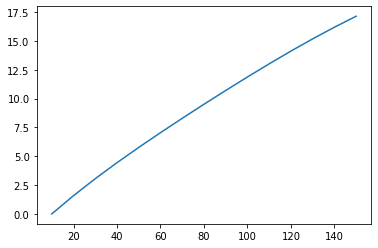

In [14]:
plt.plot(nbarfs, shifts1[4,:]*1e3, label="Ncut=901" )

In [32]:
%store -r shifts
%store -r nbarPts
%store -r nu0

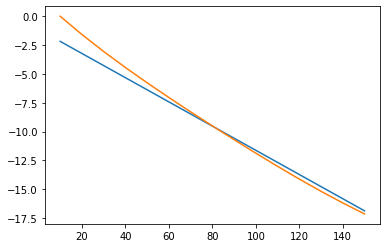

In [35]:
plt.plot(nbarPts,shifts*nu0*1.0e3, label="Ncut=1201")
plt.plot(nbarfs, -shifts1[4,:]*1e3, label="Ncut=901" )

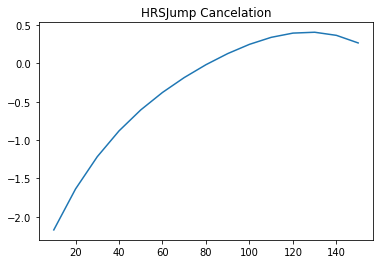

In [36]:
plt.plot(nbarfs, (shifts*nu0+shifts1[4,:])*1.0e3)
plt.title("HRSJump Cancelation")
plt.show()

In [30]:
shifts1[4,:]*1e3

array([ 0.02652321,  1.60716795,  3.07498735,  4.45812469,  5.77860698,
        7.05322366,  8.29410718,  9.50885924, 10.70050694, 11.86778403,
       13.0059567 , 14.10804228, 15.16611318, 16.17242613, 17.12024083])

In [31]:
(17.12024083-0.02652321)/140

0.122097983

In [37]:
pts = 15
Ncuts = np.array([201,401,601,801,901])
psi0 = psi(0.0, 1.0)
Delta = 1.0 #*(2.0*np.pi) #hz
Omega0 = 157.0 #*(2.0*np.pi) #hz
nbar0 = 10.0 
t1 = 3.0*np.pi/(2.0*Omega0)
t2 = np.pi/(2.0*Omega0)
T = 50.0e-3
eta = 0.05
nbarfs = np.linspace(10, 150, pts)
shifts1 = np.zeros([np.size(Ncuts), pts])
shifts2 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 5.0
for ii in range(np.size(Ncuts)):
    print(Ncuts[ii])
    x0 = -0.1
    x1 = 0.5
    for jj in range(pts):
        print(nbarfs[jj])
        shifts1[ii][jj] = sp.optimize.root_scalar(HRJumpThermErrSigFront, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarfs[jj], Ncuts[ii]), bracket=[x0,x1], xtol = tol).root
        #print(shifts1[ii])
        x0 = shifts1[ii][jj] - guessTol
        x1 = shifts1[ii][jj] + guessTol
        #print(x0,x1)

201
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
401
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
601
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
801
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
901
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


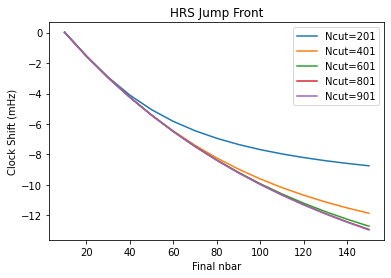

In [40]:
plt.plot(nbarfs, shifts1[0,:]*1e3, label="Ncut=201" )
plt.plot(nbarfs, shifts1[1,:]*1e3, label="Ncut=401" )
plt.plot(nbarfs, shifts1[2,:]*1e3, label="Ncut=601" )
plt.plot(nbarfs, shifts1[3,:]*1e3, label="Ncut=801" )
plt.plot(nbarfs, shifts1[4,:]*1e3, label="Ncut=901" )
plt.legend()
plt.xlabel("Final nbar")
plt.ylabel("Clock Shift (mHz)")
plt.title("HRS Jump Front")
plt.show()

In [42]:
1.5e-18*nu0*1e3

1.0325384689639618